# RESUBMISSION SUMMARY OF CHANGES

## Added much more code/ouput/discussion in the Create Models section to include parameters changes to improve model accuracy for both SVM with SGD and logistic regression models. Changed the SVM print so you could see the accuracies for each fold.

## Added more discussion in the Interpret Feature Importance Section.

## Noticed that one of your comments was that you were seeeing only 3 CV outputs even though are code says 5. Not sure how, but we are seeing 5 when we run the output.





## DS 7331 Data Mining
## Mini Lab
## 2/17/2019
## Mallory Hightower, Richard Farrow, and Brandon de la Houssaye


## Data Wrangling 

In [5]:
#import necessary packages
import pandas as pd
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sns

#import and view the data
df_no_edit = pd.read_csv ("C:/Users/brndn/OneDrive/Documents/Semester 3 Courses/Data Mining/Group Project/OlympicData/Data/Olympicdata.csv")
df_no_edit.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Examine the orginal, un-edited data set before making any changes.

In [6]:
# make all the edits to the data before using it

#drop the ID, Team, Name, Games, City and Event columns
# Games  is being dropped becuase year and season already contain that value
# Event is esentially a more specific sport, which we most likely will not need and will reduce later one-hot encoding
# City is also a little more granular and dropping it reduced later one-hot ecoding and processing speeds
df1 = df_no_edit.drop(['ID'], axis=1)
df1 = df1.drop(['Team'], axis=1)
df1 = df1.drop(['Event'], axis=1)
df1 = df1.drop(['Name'], axis=1)
df1 = df1.drop(['Games'], axis=1)
df1 = df1.drop(['City'], axis=1)

#impute Age, Height, Weight, and Medal
#replace NaN with mean of column
df1['Weight']=df1['Weight'].fillna(df1['Weight'].mean())
df1['Height']=df1['Height'].fillna(df1['Height'].mean())
df1['Age']=df1['Age'].fillna(df1['Age'].mean())

#replace the NaN in medal to "None"
df1["Medal"].fillna("None", inplace = True)

#replace the different medal categories to "Medal" to make it a binary classification
df1['Medal']= df1['Medal'].replace('Gold', 'Medal')
df1['Medal']= df1['Medal'].replace('Silver', 'Medal')
df1['Medal']= df1['Medal'].replace('Bronze', 'Medal')

df1 ['IsMedal'] =df1.Medal == 'Medal'
df1.IsMedal = df1.IsMedal.astype(np.int)
df1 = df1.drop(['Medal'], axis=1)


# replace the current Sex atribute with IsMale to avoid one hot encoding
#delete Sex attribute afterwards
df1['IsMale'] = df1.Sex=='M'
df1.IsMale = df1.IsMale.astype(np.int)
df1 = df1.drop(['Sex'], axis=1)

# replace current Season attribute with IsSummer to avoid one hot encoding
df1['IsSummer'] = df1.Season=='Summer'
df1.IsSummer = df1.IsSummer.astype(np.int)
df1 = df1.drop(['Season'], axis=1)

df=pd.get_dummies(df1, columns=['NOC', 'Sport'])

if 'NOC' in df:   
    del df['NOC']    
if 'Sport' in df:
    del df['Sport'] 

df.head()

,Age,Height,Weight,Year,IsMedal,IsMale,IsSummer,NOC_AFG,NOC_AHO,NOC_ALB,...,Sport_Table Tennis,Sport_Taekwondo,Sport_Tennis,Sport_Trampolining,Sport_Triathlon,Sport_Tug-Of-War,Sport_Volleyball,Sport_Water Polo,Sport_Weightlifting,Sport_Wrestling
0,24.0,180.00000,80.000000,1992,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23.0,170.00000,60.000000,2012,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24.0,175.33897,70.702393,1920,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34.0,175.33897,70.702393,1900,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,21.0,185.00000,82.000000,1988,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create Models

### Set up cross validation

In [8]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'IsMedal' in df:
    y = df['IsMedal'].values # get the labels we want  
    X = df.loc[:, df.columns != 'IsMedal'].values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


In [4]:

df.describe()

,Age,Height,Weight,Year,IsMedal,IsMale,IsSummer,NOC_AFG,NOC_AHO,NOC_ALB,...,Sport_Table Tennis,Sport_Taekwondo,Sport_Tennis,Sport_Trampolining,Sport_Triathlon,Sport_Tug-Of-War,Sport_Volleyball,Sport_Water Polo,Sport_Weightlifting,Sport_Wrestling
count,271116.000000,271116.00000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,...,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000
mean,25.556898,175.33897,70.702393,1978.378480,0.146738,0.725129,0.820874,0.000465,0.000291,0.000258,...,0.007211,0.002235,0.010556,0.000561,0.001951,0.000627,0.012556,0.014186,0.014521,0.026387
std,6.280857,9.27810,12.574690,29.877632,0.353845,0.446450,0.383459,0.021553,0.017068,0.016066,...,0.084611,0.047225,0.102201,0.023671,0.044129,0.025033,0.111346,0.118257,0.119627,0.160284
min,10.000000,127.00000,25.000000,1896.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,170.00000,63.000000,1960.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,175.33897,70.702393,1988.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,28.000000,180.00000,75.000000,2002.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,97.000000,226.00000,214.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# BEGINNING OF CHANGED CODE ON THE CREATE MODELS SECTION 

### Logistic Regression Model
#### This section has new code and output discussion to provide insight into changing the model parameters to increase model accuracy.

# BEGINNING OF CHANGED CODE ON THE CREATE MODELS SECTION 

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=0.3, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.8542158453821186
confusion matrix
 [[45976   257]
 [ 7648   343]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.8569637061079964
confusion matrix
 [[45939   347]
 [ 7409   529]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.8574063145470641
confusion matrix
 [[45941   427]
 [ 7305   551]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 3  ====
accuracy 0.8556358807907938
confusion matrix
 [[45813   374]
 [ 7454   583]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.8547875479492476
confusion matrix
 [[46008   209]
 [ 7665   342]]


Run the logistic regression modle with these parameters: (penalty='l2', C=0.3, class_weight=None). Seeing an accuracy of about 0.85.

In [6]:
# use the same set up as used previously, just change the parameters to make the model more accurate 
# penalty was changed to l1. 

lr_clf = LogisticRegression(penalty='l1', C=0.3, class_weight=None) 

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====Iteration 0  ====
accuracy 0.8580517851873709
confusion matrix
 [[45982   348]
 [ 7349   545]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.857904249041015
confusion matrix
 [[45939   327]
 [ 7378   580]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====Iteration 2  ====
accuracy 0.8584943936264384
confusion matrix
 [[45972   367]
 [ 7306   579]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====Iteration 3  ====
accuracy 0.8562813514311006
confusion matrix
 [[45857   352]
 [ 7441   574]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.8585497196813219
confusion matrix
 [[45986   356]
 [ 7314   568]]


We ran logistic regression again using the same cross validation and changed the penalty to l1 (previously it was l2). The penalty has to do with how the model handles overfitting the data. We do not want an overfitted model! Lasso regression uses l1 as the penalty whereas ridge regression uses l2. Lasso (l1) is useful for datasets with many attributes because it shrinks the less important attribute coefficients to 0 and works as a type of feature selection. We found that running the logistic regression with an l1 penalty dramatically increased the time to run the model but did not produce higher model accuracies. The accuracies for each iteration were all about 0.85-0.86 (as shown above in the ouput). 

In [7]:
# use the same set up as used previously, just change the parameters to make the model more accurate 
# penalty was changed back to l2
# decease C (more regularization)

lr_clf = LogisticRegression(penalty='l2', C=0.005, class_weight=None) 

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.8552670404249041
confusion matrix
 [[46246    52]
 [ 7796   130]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.8579226910593095
confusion matrix
 [[46256    99]
 [ 7605   264]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.8573878725287696
confusion matrix
 [[46267   112]
 [ 7621   224]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 3  ====
accuracy 0.8515048686928297
confusion matrix
 [[46023    55]
 [ 7997   149]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.8534228385954559
confusion matrix
 [[46124    61]
 [ 7887   152]]


After we decided to use the l2 penalty over the l1 penalty due to the much longer time to run the l1 penalty with no significant change in model accruacy, we ran logistic regression again using the same cross validation and changed the C to 0.005 (previously it was 0.3). C is the inverse of the regularization strength (lambda) and therefore smaller values mean stronger regularization. Regularization is a way of applying a penalty to the model in order to reduce overfitting. If we really want to reduce overfitting, we would use a very small C to achieve a higher regularization penalty. 

After reducing C to 0.005 (much higher regularization penalty), there were no significant changes in model accuracy. The CV fold accuracies are all about 0.85. However, it does seem that a smaller C decreases the accuracy by about 0.01. 

In [8]:
# use the same set up as used previously, just change the parameters to make the model more accurate 
# increase C (less regularization)

lr_clf = LogisticRegression(penalty='l2', C=1.5, class_weight=None) 

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.8562260253762172
confusion matrix
 [[45882   393]
 [ 7403   546]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.8534781646503393
confusion matrix
 [[45874   296]
 [ 7649   405]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.8566501917969903
confusion matrix
 [[45982   344]
 [ 7429   469]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 3  ====
accuracy 0.8548428740041311
confusion matrix
 [[45965   258]
 [ 7613   388]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.8569268220714075
confusion matrix
 [[45948   339]
 [ 7419   518]]


After we tried decreasing C to 0.005 to use a higher regularization penalty on the model, we increased C to 1.5. We wanted to see how well the model would do with a smaller regularization penalty. Increasing C means we may have an overfitted model. 

With a higher C=1.5, the CV fold accuracies are still around 0.85. No significant changes in accuracy by increasing C to 1.5.

In [9]:
# use the same set up as used previously, just change the parameters to make the model more accurate 
# increase C to a much higher number (less regularization)

lr_clf = LogisticRegression(penalty='l2', C=20, class_weight=None) 

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.8548613160224255
confusion matrix
 [[45876   347]
 [ 7523   478]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.8541605193272351
confusion matrix
 [[45871   332]
 [ 7576   445]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.8574985246385365
confusion matrix
 [[45950   299]
 [ 7428   547]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 3  ====
accuracy 0.8578304809678371
confusion matrix
 [[45897   440]
 [ 7269   618]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.8540683092357627
confusion matrix
 [[45850   239]
 [ 7674   461]]


Just to see what happens, we increased C to a very large number: 20. This essentially tells the model to have a very low penalty for overfitting. We were curious to see if we could achieve any higher accuracies, even at the risk of overfitting. 

It looks like even though we really increased C, the accuracy of the models only inceased by about 0.001. It is not worth it to risk overfitting the model for such a small increase in accuracy. We will resort to using the middle grounnd regularization penalty of 0.3 (the defualt is 1).

In [10]:
# use the same set up as used previously, just change the parameters to make the model more accurate 
# change to class_weight=balanced (vs None)

lr_clf = LogisticRegression(penalty='l2', C=0.3, class_weight='balanced') 

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.6728385954558866
confusion matrix
 [[31064 15287]
 [ 2453  5420]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.6758446444378873
confusion matrix
 [[31298 15075]
 [ 2502  5349]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.6731889938034818
confusion matrix
 [[31013 15199]
 [ 2522  5490]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 3  ====
accuracy 0.6764901150781941
confusion matrix
 [[31207 15064]
 [ 2478  5475]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.6743139569194453
confusion matrix
 [[31025 15328]
 [ 2332  5539]]


In [11]:
# use the same set up as used previously, just change the parameters to make the model more accurate 
# increase C (less regularization)

lr_clf = LogisticRegression(penalty='l2', C=20, class_weight='balanced') 

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.6754942460902921
confusion matrix
 [[31061 15141]
 [ 2455  5567]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.6728017114192977
confusion matrix
 [[31032 15279]
 [ 2463  5450]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.6707362053703158
confusion matrix
 [[30775 15464]
 [ 2390  5595]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 3  ====
accuracy 0.6769142814989673
confusion matrix
 [[31110 15032]
 [ 2487  5595]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.6695190321628799
confusion matrix
 [[30815 15559]
 [ 2361  5489]]


We used class_weight=balanced and increased C to 20. We do not see any significant changes in the accuracy or the confusion matrices with a lower regularization penalty (higher C value). The accuracy is still around 0.67.

In [12]:
# use the same set up as used previously, just change the parameters to make the model more accurate 
# decrease C by a lot! (more regularization)

lr_clf = LogisticRegression(penalty='l2', C=0.00001, class_weight='balanced') 

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.5371237828267925
confusion matrix
 [[24234 22023]
 [ 3076  4891]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.5366627323694305
confusion matrix
 [[24227 22093]
 [ 3031  4873]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.5355008852168781
confusion matrix
 [[24219 22149]
 [ 3038  4818]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 3  ====
accuracy 0.5385622602537622
confusion matrix
 [[24228 21879]
 [ 3142  4975]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.5347263204485099
confusion matrix
 [[24067 22160]
 [ 3069  4928]]


We found that significantly decreasing C actually decreased the accruacy to 0.54 and increased the number of false positives. Not good for the model!

In [13]:
# use the same set up as used previously, just change the parameters to make the model more accurate 
# decrease C by a little! (more regularization)

lr_clf = LogisticRegression(penalty='l2', C=0.01, class_weight='balanced') 

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.6784080849808203
confusion matrix
 [[31522 14894]
 [ 2544  5264]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.6766929772794334
confusion matrix
 [[31372 14830]
 [ 2701  5321]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.6832583357922691
confusion matrix
 [[31719 14508]
 [ 2667  5330]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 3  ====
accuracy 0.6825022130421954
confusion matrix
 [[31667 14546]
 [ 2670  5341]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 4  ====
accuracy 0.6834611979935085
confusion matrix
 [[31687 14548]
 [ 2616  5373]]


We found that decreasing C below the default of C=1 to 0.01 increased the accuracy to about 0.68 without too much change in the confusion matrix values for the false negatives and true negatives (we really want to avoid a model that just predicts the majority class). 

After adjusting the parameters of the model several times to make the model more accurate, we chose the above parameters (the last cross validation output shown above) (penalty='l2', C=0.01, class_weight='balanced').

We chose shuffle split cross validation for our cross validation data splitting technique with an 80/20 training/testing split. Because shuffle split does not divide the training data into distinct splits, but rather randomly shuffles the training data and samples again, we used 5 iterations because we wanted to ensure more data had the possiblity of being included in the cross validation splits. 

For the logistic regression cross validation output, we are getting accuracies consistently around 68%. This is not bad! However, accuracy is not always the best metric for model performance, especially with severly unbalanced data sets. 

This is why we also printed the confusion matrices for each model to achieve a more granular understanding of model performance. On average, it looks like this model has about 31,700 true positives (correct predictions), 14,500 false positives, 2,600 false negatives, and 5,300 true negatives. While these are not bad metrics, there is still some left for improvement!

### Stochastic Gradient Descent Classifier with linear Support Vector Machine Model
#### This code was changed to move the print line up to see the accuracies of each split for the model
#### New code and output discussion was also added on changing the parameters of the model

In [14]:
# run linear support vector machines (SVM) to see how well a SVM model generalizes to the data

# because of the large size of our data set, we will be using stochastic gradient descent (SGD)
# because we are using SGD, we will not use cross-validation as SGD passes over the entire training set several 
# time to optimize it (we set our number of iterations to 4)

# standardize the data before applying the SVM


# use some compact notation for creating a linear SVM classifier with stochastic descent

from sklearn.linear_model import SGDClassifier
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

regularize_const = 0.2
iterations = 4
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', max_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    print('SVM with SGD Accuracy:', acc) 
    print('Confusion Matrix', conf)
  
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.6834611979935085
Confusion Matrix [[31687 14548]
 [ 2616  5373]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8537547949247566
Confusion Matrix [[46186    15]
 [ 7915   108]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8562075833579227
Confusion Matrix [[46342    15]
 [ 7782    85]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8565395396872234
Confusion Matrix [[46353    18]
 [ 7761    92]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8545293596931248
Confusion Matrix [[46236    13]
 [ 7875   100]]


With an alpha of 0.2, l2 penalty, and  l1_ratio=0.0 we achieved accuracies of 0.85. This is a much higher accuracy range than we were seeing with the logistic regression. It is worthy to note that there are very few true negatives.

In [15]:
regularize_const = 0.2
iterations = 4
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', max_iter=iterations, n_jobs=-1, penalty='l1')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    print('SVM with SGD Accuracy:', acc) 
    print('Confusion Matrix', conf)
  
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8547137798760697
Confusion Matrix [[46266    15]
 [ 7863    80]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8510253762171732
Confusion Matrix [[46146     0]
 [ 8078     0]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8531646503393331
Confusion Matrix [[46262     0]
 [ 7962     0]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8515417527294187
Confusion Matrix [[46174     0]
 [ 8050     0]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8511729123635291
Confusion Matrix [[46154     0]
 [ 8070     0]]


With an alpha of 0.2, l1 penalty, and  l1_ratio=0.0 we achieved accuracies of about 0.85. Not a significant change in accuracy from changing the l1 vs l2 penalty. However, there are very few false postives or true negatives, so reverting back to l2 penalty.

In [16]:
regularize_const = 5
iterations = 4
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', max_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    print('SVM with SGD Accuracy:', acc) 
    print('Confusion Matrix', conf)
  
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8535519327235173
Confusion Matrix [[46283     0]
 [ 7941     0]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8520765712599587
Confusion Matrix [[46203     0]
 [ 8021     0]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8566133077604013
Confusion Matrix [[46449     0]
 [ 7775     0]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8563920035408675
Confusion Matrix [[46437     0]
 [ 7787     0]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.856410445559162
Confusion Matrix [[46438     0]
 [ 7786     0]]


With an alpha of 5, a much higher regularization multiplier, l2 penalty, and  l1_ratio=0.0 we achieved accuracies of about 0.85, but with very few false postives or true negatives. Reverting back to a smaller alpha.

In [17]:
regularize_const = 0.001
iterations = 4
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=1, learning_rate='optimal',
        loss='hinge', max_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    print('SVM with SGD Accuracy:', acc) 
    print('Confusion Matrix', conf)
  
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8544924756565359
Confusion Matrix [[46334     0]
 [ 7890     0]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8555436706993214
Confusion Matrix [[46301    72]
 [ 7761    90]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8529433461197994
Confusion Matrix [[46148   143]
 [ 7831   102]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8544002655650634
Confusion Matrix [[46167   206]
 [ 7689   162]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8553961345529655
Confusion Matrix [[46224   103]
 [ 7738   159]]


With an alpha of 0.001, a smaller regularization multiplier, l2 penalty, and  higher l1_ratio=1 we achieved accuracies of about 0.85, but with more false positives. Reverting back to a smaller l1_ratio.

In [18]:
regularize_const = 0.001
iterations = 4
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.001, learning_rate='optimal',
        loss='hinge', max_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    print('SVM with SGD Accuracy:', acc) 
    print('Confusion Matrix', conf)
  
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8556912068456772
Confusion Matrix [[46323    40]
 [ 7785    76]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8531830923576276
Confusion Matrix [[46108   179]
 [ 7782   155]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8526113897904987
Confusion Matrix [[46126    62]
 [ 7930   106]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8519659191501918
Confusion Matrix [[46118    87]
 [ 7940    79]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8530171141929773
Confusion Matrix [[46136    80]
 [ 7890   118]]


With an alpha of 0.001, l2 penalty, and  much smaller l1_ratio=0.001 we achieved accuracies of about 0.85, but with many more false positives. Reverting back to a l1_ratio=0. This makes sense since the l1_ratio=0 corresponds to an l2 penalty, which is what we are using!

In [19]:
regularize_const = 0.001
iterations = 4
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', max_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    print('SVM with SGD Accuracy:', acc) 
    print('Confusion Matrix', conf)
  
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8526113897904987
Confusion Matrix [[46094   148]
 [ 7844   138]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8534781646503393
Confusion Matrix [[46161   192]
 [ 7753   118]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8514311006196518
Confusion Matrix [[46013   164]
 [ 7892   155]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8521318973148422
Confusion Matrix [[46078   231]
 [ 7787   128]]


C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SVM with SGD Accuracy: 0.8518737090587194
Confusion Matrix [[46050   229]
 [ 7803   142]]


From the final SVM with SGD ouput above, after changing different parameters, the model accuracy is about 85%. 

From the matrix: there are about 46,000 true positives, 70-300 false positives, 7,800 false negatives, and 100-200 true negatives. 

The time to run this SVM with SGD model runs faster than the logistic regression model. This is with 4 iterations.

# END OF CHANGED CODE ON THE CREATE MODELS SECTION 

## Model Advantages
#### this commentary was changed as well, since we ended up getting a lower accuracy score for the logistic regression model

The confusion matrices for the SVM with SGD and logistic regression using cross validation do not present drastically different results, but they are different. The biggest difference is when you weight the minority class more in logistic regression using class_weight=balance. 

The SVM with SGD model has about 46,000 true positives, 70-300 false positives (predicted a medal when there was none awarded), 7,800 false negatives (predicted no medal when a medal was actually awarded) and 100-200 true negatives (predicted no medal and no medal was awarded. The logistic regression model has about 31,700 true positives, 14,500 false positives, 2,600 false negatives, and 5,300 true negatives. Because the logsitic regression has a way to weight the unbalanaced classes, the logistic regression model does a better job at predicting true negatives. 

However, the accuracies of the SVM with SGD model is about 85% whereas the accuracy of the logistic regression model is 67%. 
From interpreting the confusion matrices as well as the accuracies, it looks like the logistic regression model may do a better job at actually correctly predicting the unbalanced classes and not just assigning the majority class all the time.

However, there are other ways that one model could be preferred over another, such as time to compute, training time and efficiency.  

Due to the size of our data set, we could not perform the cross validation for SVM in a reasonable time, so we had to use the SGD classifier to optimize the SVM model. The SVM with SGD works by iterating over the data multiple times. If you want to perform cross validation, the logistic regression model is much preferred to the SVM model because just using an SVM model with cross validation takes a LONG time (days) to run on our large data set.

In terms of training time/running time/computing time, the time to run the 5 cross-validation splits with the logistic regression model was longer due to the time required for each iteration of cross validation. The SVM with SGD takes about half the time to run wih its iterations.  

In conclusion, the time to run the two models is not drastically different, but the perforamnce of the models is different due to the unbalanced classes. 


# BEGINNING OF CHANGED CODE ON THE INTERPRET FEATURE IMPORTANCE SECTION 

## Interpret Feature Importance

### Eliminate Insignificant Variables

What follows is a review of the coefficients from the logistic model in order to determine what, if any, features can be eliminated from the model in order to increase the interpretation of the model without sacrificing the model's core features (i.e., accuracy).

In [20]:
# eliminate variables that are not significant

# because our dataset has so many attributes, we wil first run an OLS model on the data and look at the individual p-values 
# as a means of data reduction

# attributes with a p-value greater than or equal to 0.05 are considered not signficant at the 95% confidence level

import statsmodels.api as sm

OLS_model=sm.OLS(y_train, X_train) # use the previously defined X_train and y_train
result=OLS_model.fit()
print(result.summary())

C:\Users\brndn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     90.26
Date:                Mon, 25 Feb 2019   Prob (F-statistic):               0.00
Time:                        18:44:31   Log-Likelihood:                -69562.
No. Observations:              216892   AIC:                         1.397e+05
Df Residuals:                  216591   BIC:                         1.428e+05
Df Model:                         300                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0017      0.000     11.683      0.0

The OLS model results above were pulled and considered with one key statistical variable in mind: p-value.  The team wanted to consider all of the coefficients available and determine if any were not statistically significant (p-value >= 5%).  Unfortunately (or fortunately for predictability purposes), very, very few features were deemed to be statistically insignificant.  That is, most of the features had a p-value less than 5%.  As a result, the potential of limiting features based on p-values was not utilized.

As a result, we considered using a recursive feature elimination (RFE):

In [21]:
from sklearn.feature_selection import RFE  

for train_indices, test_indices in cv_object.split(X,y):     
    X_train = X[train_indices]
    y_train = y[train_indices]

rfe = RFE(lr_clf, 30)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False  True False False False False False
  True False False False False False False False False False  True False
 False False False False False False False False False False  True False
 False False False False False  True False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

The RFE parameters set the sought features to 30.  The nature of the RFE is that feature is removed and the model is run, and so one (with an additional feature being removed each time) until the paramterized number of features is remaining.  Given the sheer number of features considered (300+) and the goal of getting a logistic model that is also interpretable, the RFE was used to eliminate features.  What follows below is an updated model with the RFE selected features.

In [29]:
cols = [col for col in df.columns if col in['IsMedal','NOC_COL','NOC_EGY','NOC_EUN','NOC_GDR','NOC_HKG','NOC_IRL','NOC_ISR','NOC_LUX','NOC_MEX','NOC_POR','NOC_PUR','NOC_RUS','NOC_URS','NOC_USA','NOC_VEN','Sport_Alpine Skiing','Sport_Art Competitions','Sport_Baseball','Sport_Curling','Sport_Football','Sport_Handball','Sport_Hockey','Sport_Ice Hockey','Sport_Polo','Sport_Rowing','Sport_Rugby','Sport_Softball','Sport_Tug-Of-War','Sport_Volleyball','Sport_Water Polo']]
df_final = df[cols]        

In [30]:
# view the new data
df_final.describe()

,IsMedal,NOC_COL,NOC_EGY,NOC_EUN,NOC_GDR,NOC_HKG,NOC_IRL,NOC_ISR,NOC_LUX,NOC_MEX,...,Sport_Handball,Sport_Hockey,Sport_Ice Hockey,Sport_Polo,Sport_Rowing,Sport_Rugby,Sport_Softball,Sport_Tug-Of-War,Sport_Volleyball,Sport_Water Polo
count,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,...,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000,271116.000000
mean,0.146738,0.003943,0.005983,0.003187,0.009756,0.002527,0.004887,0.002453,0.003674,0.010623,...,0.013518,0.019980,0.020346,0.000350,0.039079,0.000598,0.001763,0.000627,0.012556,0.014186
std,0.353845,0.062669,0.077116,0.056362,0.098290,0.050202,0.069738,0.049465,0.060500,0.102518,...,0.115479,0.139933,0.141180,0.018716,0.193784,0.024437,0.041952,0.025033,0.111346,0.118257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# first we must create new X and y arrays (X2, y2)

from sklearn.model_selection import ShuffleSplit

# we want to predict the X2 and y2 data as follows:
if 'IsMedal' in df_final:
    y2 = df_final['IsMedal'].values # get the labels we want  
    X2 = df_final.loc[:, df_final.columns != 'IsMedal'].values # use everything else to predict!

# X2 and y2 are now numpy matrices, by calling 'values' on the pandas data frames we
# have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits
# create a test size that is 20% of the data (80/20 split)
num_cv_iterations = 5  
num_instances = len(y2)
cv_object = ShuffleSplit(n_splits=num_cv_iterations, test_size  = 0.2)
#view the object                          
print(cv_object)

ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


In [32]:
# now create new training and testing sets with the reduced data

for train_indices, test_indices in cv_object.split(X2,y2): 
    X_train = X2[train_indices]
    y_train = y2[train_indices]
    
    X_test = X2[test_indices]
    y_test = y2[test_indices]         

### Logistic Regression Model on scaled data

In [33]:
# now that we have removed insignificant attributes, we can run the logistic model and interpret the coefficients (scale them first 
# in order to intrepret them correctly)

from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
# X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.01, class_weight='balanced') # get object
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and print them
zip_vars = zip(lr_clf.coef_.T,df_final.loc[:, df_final.columns != 'IsMedal']) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out



C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\brndn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 0.751567571555031
[[36916  9511]
 [ 3960  3837]]
NOC_LUX has weight of -0.19084940570374145
NOC_HKG has weight of -0.1742439325590232
NOC_EGY has weight of -0.17034519782902055
Sport_Alpine Skiing has weight of -0.16586842442883132
NOC_PUR has weight of -0.1520570833252802
NOC_MEX has weight of -0.13733389477184038
Sport_Art Competitions has weight of -0.13084973831817473
NOC_POR has weight of -0.12768141208851305
NOC_VEN has weight of -0.12345685024430031
NOC_IRL has weight of -0.12143275099058513
NOC_COL has weight of -0.11315337985281454
NOC_ISR has weight of -0.10759295551169715
Sport_Curling has weight of 0.055152371069320714
Sport_Softball has weight of 0.059218389440451616
Sport_Polo has weight of 0.05954812330773339
NOC_EUN has weight of 0.06710092551230248
Sport_Tug-Of-War has weight of 0.07437356212386259
Sport_Baseball has weight of 0.08483095635589441
Sport_Volleyball has weight of 0.10022588656803788
NOC_RUS has weight of 0.10437005197302295
Sport_Water Polo has 

Our new logistic regression model has an accuracy of 75%. 

The model has about approximately 37,000 true positives, 9,500 false positives, 3,900 false negatives, and 3,800 true negatives. These model metrics are very similar to the previous cross validation logistic regresssion metrics.

# BEGINNING OF CHANGED CODE ON THE INTERPRET FEATURE IMPORTANCE SECTION 

### Interpret the Logistic Regression Coefficients

As has been discussed in the prior lab as well as throughout this report, the dataset being considered and analyzed is intrinsically difficult with respect to interpretability as part of a logistics regression model.  Put another way, the original data set contained a handful of variables, such as country, sport, or year, and many of these variables contained hundreds of classes (i.e., country variable has a different class for each country that competes in the games).  Building a logistic regression model requires assigning a numerical, binary aspect to each class for each variable in order to understand that particular class and its ability to predict a given output.  

What does this all mean?  Before we began eliminating features and after we structured the data to build a model, we established 302 prediction features.  302!  Writing that model alone and asking a human mind to appreciate and analyze all of the coefficients is clearly too much.  

After performing the RFE, the features that remained as a result of the RFE were all class levels of the core variables related to country or sport.  Country features provided the highest predictive coefficients (US ~ 0.28, URS ~ 0.24, LUX ~ -0.19, HKG ~ - 0.17, etc.).  Sports such as rowing (~0.18), rugby (~0.17), hockey (~0.16), football (~0.14), ice hockey (~0.13), handball (~0.13), water polo (~0.12), volleyball (~0.10), baseball (~0.08), tug-of-war (~ 0.07), polo (~ 0.06), softball (~ 0.06), and curling (~ 0.06) were the only sport related features that had positive coefficients (i.e., you were more likely to win a medal if you played in that sport).  These sports all shared another feature; they were all team sports.  Whereas sports such as alpine skiing (~ -0.17) and sport-art competitions (~ -0.13) are individual sports.  This seems to make sense: if you were part of team (and the winning team is awarded a metal to each participant), your odds of winning a medal would seem to increase if your sport had less teams participating (such as rugby or polo) and greater numbers of team members (such as ice hockey).

The country results are interesting in that there seems to be clear dichotomy between high performing countries (as mentioned previously this would include USA, URS, and RUS ~ 0.10) and low performing countries (LUX, HKG, EGY ~ -0.17, PUR ~ -0.15, or MEX ~ -0.14).  This is somewhat to be expected again.  USSR (including Russia since that political change) and the USA often competed for metal supremacy; merely making those teams was in itself a difficult competition so it stands to reason that once you made the team...your chances of medalling were high.  Likewise, Hong Kong or Luxembourg are not necessarily populous countries known for fostering athletic talent.  Thus, even if you made it to the Olympics, if you were part of those country contingents you are competing against athletes that went through the grueling selection process in more competitive countries.  

As has been discussed previously, a key consideration going forward is whether RFE is worthwhile as a step.  While eliminating so many features makes interpreting the model easier (for a human user), it also makes the model potentially less useful.  For example, if the athlete was competing in track and field and came from Brazil, the model would have difficulty providing a useful prediction as those features are not even represented!



In [34]:
#create a dataframe using zip array for plotting
plt_df = pd.DataFrame(columns=['col','val'])
i = 0
for coef, name in zip_vars:
   plt_df.loc[i] = [name,coef[0]]
   i+=1

plt_df.head(50)

,col,val
0,NOC_LUX,-0.190849
1,NOC_HKG,-0.174244
2,NOC_EGY,-0.170345
3,Sport_Alpine Skiing,-0.165868
4,NOC_PUR,-0.152057
5,NOC_MEX,-0.137334
6,Sport_Art Competitions,-0.130850
7,NOC_POR,-0.127681
8,NOC_VEN,-0.123457
9,NOC_IRL,-0.121433


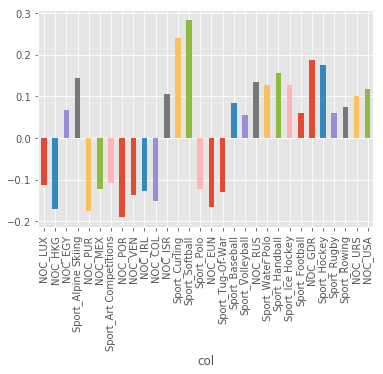

In [36]:
# let's graph the coefficients and make it easier to see all the values at once

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
#plt.bar(plt_df['col'],plt_df['val'])

weights = pd.Series(lr_clf.coef_[0],index=plt_df['col'])
weights.plot(kind='bar')
plt.show()

# END OF CHANGED CODE ON THE INTERPRET FEATURE IMPORTANCE SECTION 

## Interpret Support Vectors

In [9]:
# train the model with just SVM.. but use a VERY small sample of the model so it runs in a timely manner
from sklearn.svm import SVC

# randomly sample a subset of the df for the SVM model

df_svm = df.sample(frac=0.05)

# we want to predict the X3 and y3 data as follows:
if 'IsMedal' in df_svm:
    y3 = df_svm['IsMedal'].values # get the labels we want  
    X3 = df_svm.loc[:, df_svm.columns != 'IsMedal'].values # use everything else to predict!

for train_indices, test_indices in cv_object.split(X3,y3): 
    X_train = X3[train_indices]
    y_train = y3[train_indices]
    
    X_test = X3[test_indices]
    y_test = y3[test_indices]

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

NameError: name 'scl_obj' is not defined

Running the SVM on just 5% of the data computed very quickly (in contrast to the days it took to run SVM on the 80% training data). 

The accuracy is not bad at 85%. It is about the same accuracy of the other models. It is interesting to note that there are 0 false positives. 

In [38]:
# look at the support vectors from the SVM model
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )


(3121, 30)
(3121,)
[1578 1543]


In [39]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now let's look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_svm.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3121 entries, 224049 to 218590
Data columns (total 31 columns):
IsMedal                   3121 non-null int32
NOC_COL                   3121 non-null uint8
NOC_EGY                   3121 non-null uint8
NOC_EUN                   3121 non-null uint8
NOC_GDR                   3121 non-null uint8
NOC_HKG                   3121 non-null uint8
NOC_IRL                   3121 non-null uint8
NOC_ISR                   3121 non-null uint8
NOC_LUX                   3121 non-null uint8
NOC_MEX                   3121 non-null uint8
NOC_POR                   3121 non-null uint8
NOC_PUR                   3121 non-null uint8
NOC_RUS                   3121 non-null uint8
NOC_URS                   3121 non-null uint8
NOC_USA                   3121 non-null uint8
NOC_VEN                   3121 non-null uint8
Sport_Alpine Skiing       3121 non-null uint8
Sport_Art Competitions    3121 non-null uint8
Sport_Baseball            3121 non-null uint8
Sport_Curlin

### Plot the Support Vectors 

KeyError: 'Column not found: Age'

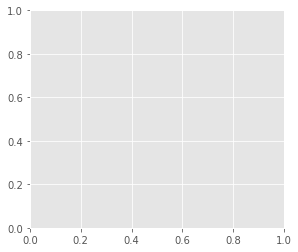

In [40]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['IsMedal'])
df_grouped = df_svm.groupby(['IsMedal'])

# plot KDE of Different variables
vars_to_plot = ['Age','Height','IsMale','Weight']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Medal','None'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Medal','None'])
    plt.title(v+' (Original)')

The support vector analysis shows the original statistics of these variables as well as the statistics of the support vectors.  
We chose just to look at a few interesting variables that were chosen as support vectors: Age, Height, IsMale, and Weight.

The separation in distributions (the distance between the orange and blue lines) between None and Medal for all of the above vairiables is greater that the separation in None and Medal distributions for the support vectors. Support vectors are usually the instances in the data that are close to the class boundary (close to the None and Medal class boundary) which is why the distribution separation is not as large. Support vectors are also the instances that are frequenlty missclassified (beacause they are on the edge of the classificaiton boundary).

From looking at just these four support vector distribution separations, it looks like there are many instances that lie on the Medal and None classification boundary for Weight, Height, and Age. It is harder to correctly classify with these attributes. We could have already guessed this with our previous exploratory data analysis: the distributions of Age, Height, and Weight were very tight and similar for the Olympic athletes who both medaled and didn't medal. 

The IsMale attribute has a greater separation between the classes, meaning there are less of the IsMale instances lying on the classification boundary. This further indicates that IsMale is a good predictor for the Medal or None because there is a large distribution separation in the original data.